# Saccade visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2  
import imageio
import pandas as pd
import seaborn as sns
import glob
import scipy.io
import os
from collections import Counter
from scipy.io.arff import loadarff 
from skimage.segmentation import mark_boundaries, slic

# Event classification visualization

In [ ]:
GAZEPATH = '/home/nico/project_data/DHF1K/gaze_record/'
VIDEOPATH = '/home/nico/project_data/DHF1K/video/'
EVENTPATH = '/home/nico/project_code/deep_em_classifier/DHF1K_arff/events_vid1-50_600-650/'
translate_dict = {'NOISE':0, 'FIX':1, 'SP':2, 'SACCADE':3}

screen_res_x = 1440; screen_res_y = 900
video_res_x = 640
video_res_y = 360
a=video_res_x/screen_res_x
# size of unused screen in y direction
b=(screen_res_y-video_res_y/a)/2
fps=30
fourcc = cv2.VideoWriter_fourcc(*'DIVX')

videos_run = [2]
subjects_run = [1] #[s+1 for s in range(17)]

markersize = 50
maxframes = 1000

SLIC = False
n_segments = 200
compactness = 10


for v in videos_run:
    videoloc = VIDEOPATH + f'{v:03}.AVI'
    vid = imageio.get_reader(videoloc,  'ffmpeg')
    vidlist = []
    for image in vid.iter_data():
        vidlist.append(np.array(image))
    for s in subjects_run:
        nframes = len(vidlist)
        txtloc = GAZEPATH + f'P{s:02}/P{s:02}_Trail{v:03}.txt'
        df = pd.read_csv(txtloc, sep='\t')
        df = df.drop(columns=['Type', 'Trial', 'L Dia X [px]', 'L Dia Y [px]'])
        df.columns = ['time', 'x', 'y', 'event_tracker']
        # set absolute timestamp (in micro seconds) relative to video start
        df['time']-=df['time'][0]
        eventlist = np.load(EVENTPATH + f'vid{v:03}_sub{s:02}_eventlist.npy', allow_pickle=True)
        # event_num is just for visualization
        event_num = list(map(lambda x: translate_dict[x], eventlist))
        # classification added to dataframe for later filtering
        df['event_class'] = eventlist
        # just use gaze that actually was on the video
        df = df[df['y'] >= b]
        df = df[df['y'] < screen_res_y-b]
        df = df[df['x'] >= 0]
        df = df[df['x'] < screen_res_x]
        # and rescale them from screen to the target/video resolution
        df['x'] = np.round(df['x']*a)
        df['y'] = np.round((df['y']-b)*a)
        scanpath = []
        video_name = f'eventVisual_vid{v:03}_sub{s:02}_{maxframes}frames.avi'
        if SLIC:
            video_name = 'slic_'+video_name
        print(video_name)
        # 10 fps, output format due to additional plot, usually (640,360)
        video = cv2.VideoWriter('videos_event-class-vis/' + video_name, fourcc, 10, (1200,800))
        # go to either the full video or only through a certain number of frames
        for f in range(min(maxframes,len(vidlist))):
            dtemp = df[(df['time'] > 1e6*f/fps) & (df['time'] < 1e6*(f+1)/fps)]
            fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [5, 1], 'wspace':0, 'hspace':0.05}, dpi=200)
            fig.suptitle(f'Video {v:03}, Subject {s:02}, Frame {f+1:04}')
            image = vidlist[f]
            if SLIC:
                label = slic(image, compactness=compactness, n_segments=n_segments, convert2lab = True)
                image = mark_boundaries(image, label) 

            axs[0].imshow(image)
            # filter the df for different events to plot them in different colors
            dfix = dtemp[dtemp['event_class']=='FIX']
            dfix.plot.scatter(x='x', y='y', c='red', ax=axs[0], s=markersize, alpha=.3, marker='o')
            dsp = dtemp[dtemp['event_class']=='SP']
            dsp.plot.scatter(x='x', y='y', c='DarkBlue', ax=axs[0], s=markersize, alpha=.3, marker='o')
            dsac = dtemp[dtemp['event_class']=='SACCADE']
            dsac.plot.scatter(x='x', y='y', c='DarkGreen', ax=axs[0], s=markersize, alpha=.8, marker='x')
            dnoise = dtemp[dtemp['event_class']=='NOISE']
            dnoise.plot.scatter(x='x', y='y', c='white', ax=axs[0], s=markersize, alpha=.8, marker='x')
            axs[0].axis('off')
            # plot where in the event-timeline we currently are
            axs[1].plot(event_num)
            axs[1].set_yticks([0,1,2,3]); axs[1].set_yticklabels(translate_dict.keys())
            axs[1].axvline(250/fps*f, color='red')
            axs[1].set_xticks([], [])
            
            canvas = FigureCanvas(fig)
            canvas.draw()
            width, height = fig.get_size_inches() * fig.get_dpi()
            temp = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)  
            temp = cv2.cvtColor(temp,cv2.COLOR_RGB2BGR)

            video.write(temp)
            plt.close('all'); del temp
        video.release(); del video
        print('done!')




eventVisual_vid002_sub01_1000frames.avi


## CAUTION: somehow running out of RAM with visualization (still no idea why...)

In [3]:
import sys
# check why ram might be full...
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df', 1088677),
 ('eventlist', 198224),
 ('event_num', 58264),
 ('vidlist', 7056),
 ('Rectangle', 3096),
 ('dtemp', 1288),
 ('Circle', 1056),
 ('Counter', 1056),
 ('FigureCanvas', 888),
 ('dsac', 664),
 ('dfix', 648),
 ('translate_dict', 240),
 ('image', 152),
 ('loadarff', 136),
 ('EVENTPATH', 126),
 ('txtloc', 111),
 ('axs', 96),
 ('videoloc', 92),
 ('GAZEPATH', 91),
 ('VIDEOPATH', 85),
 ('Image', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('video_name', 77),
 ('c_blue', 72),
 ('c_green', 72),
 ('c_red', 72),
 ('subjects_run', 72),
 ('videos_run', 72),
 ('scanpath', 64),
 ('canvas', 56),
 ('fig', 56),
 ('vid', 56),
 ('fourcc', 32),
 ('height', 32),
 ('video', 32),
 ('width', 32),
 ('f', 28),
 ('fps', 28),
 ('markersize', 28),
 ('maxframes', 28),
 ('nframes', 28),
 ('s', 28),
 ('screen_res_x', 28),
 ('screen_res_y', 28),
 ('v', 28),
 ('video_res_x', 28),
 ('video_res_y', 28),
 ('a', 24),
 ('b', 24),
 ('dnoise', 24),
 ('dsp', 24)]

# Simple plotting of all raw data in one frame

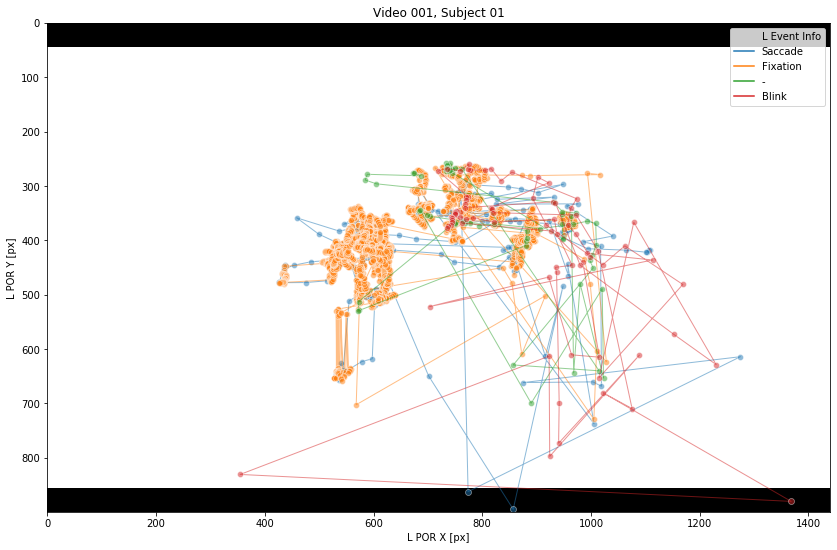

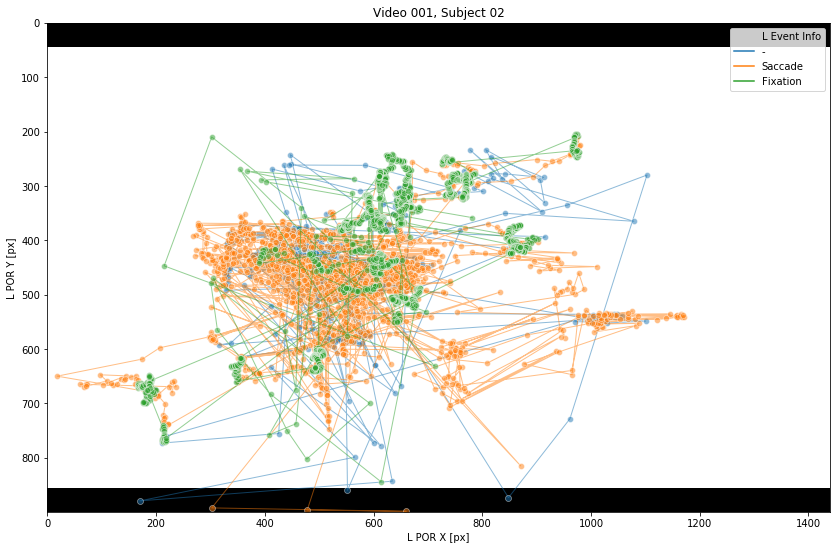

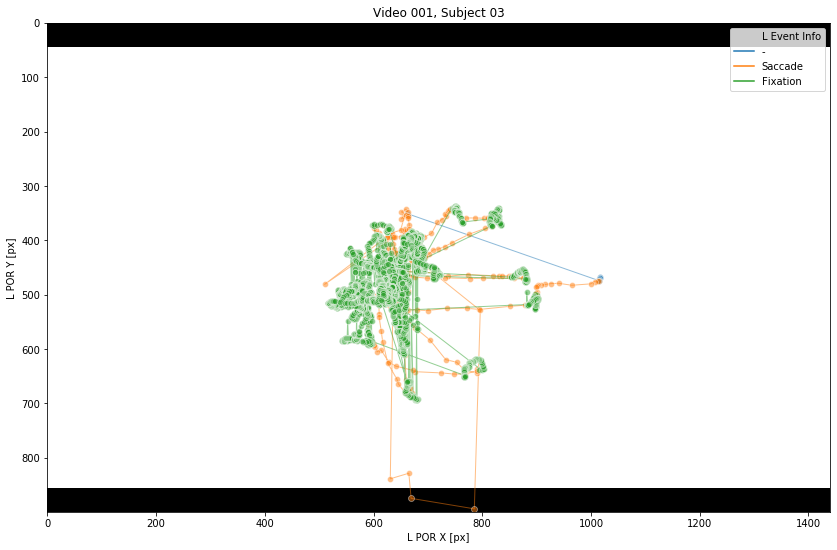

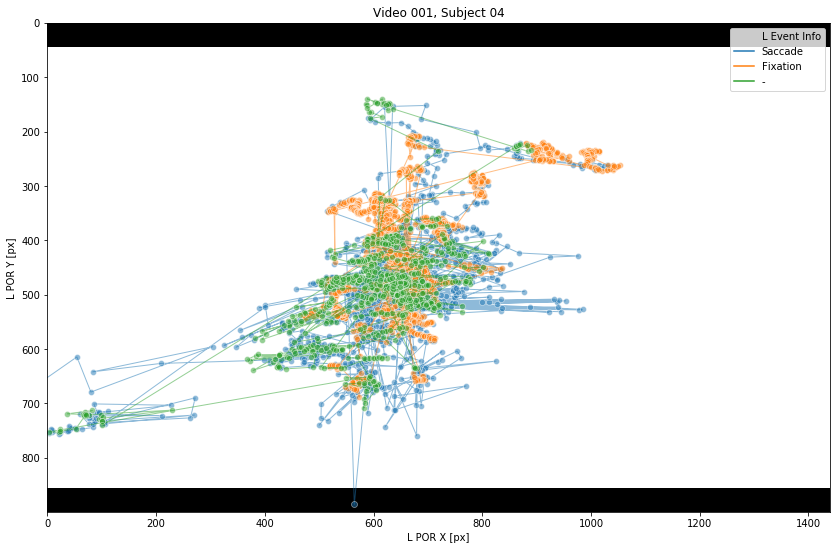

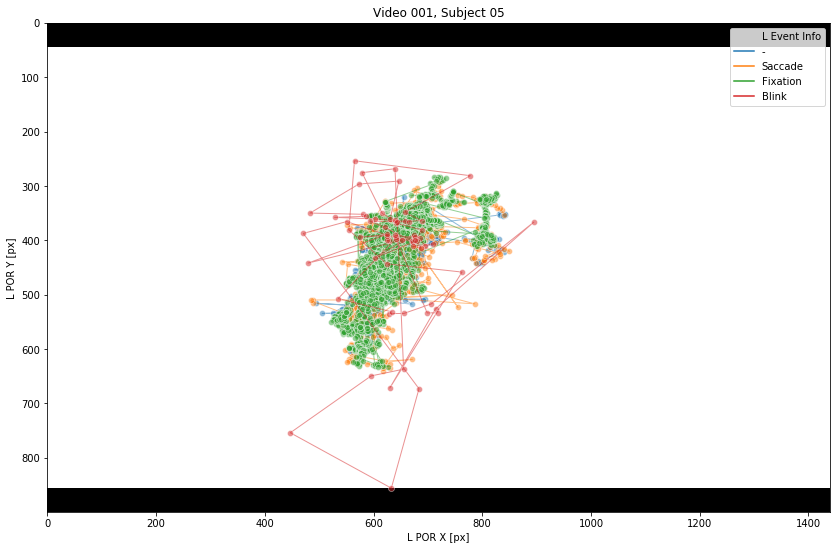

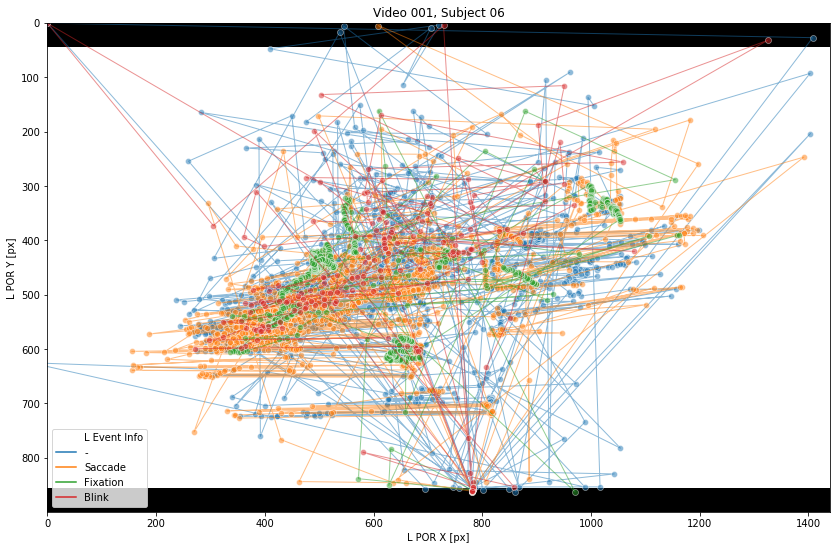

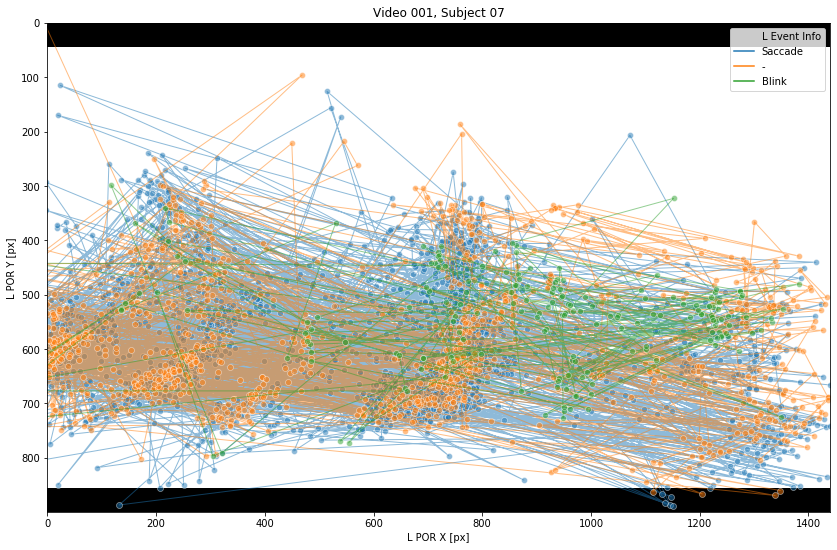

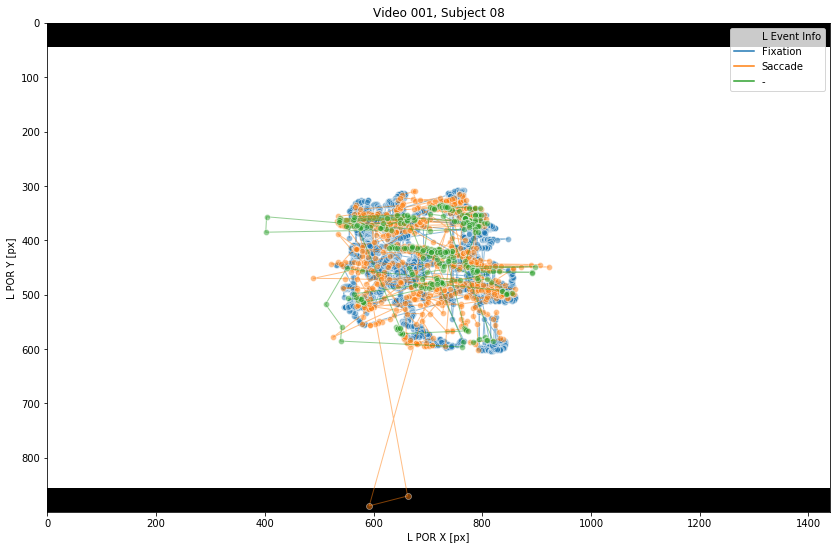

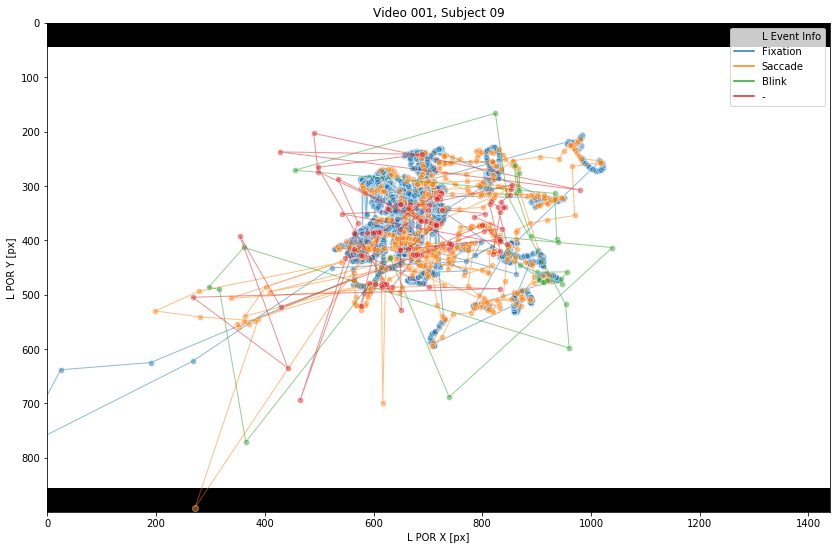

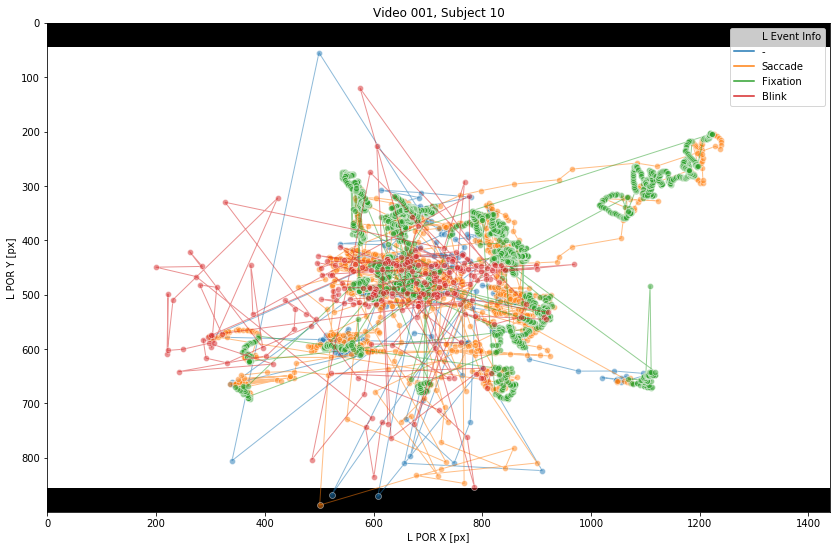

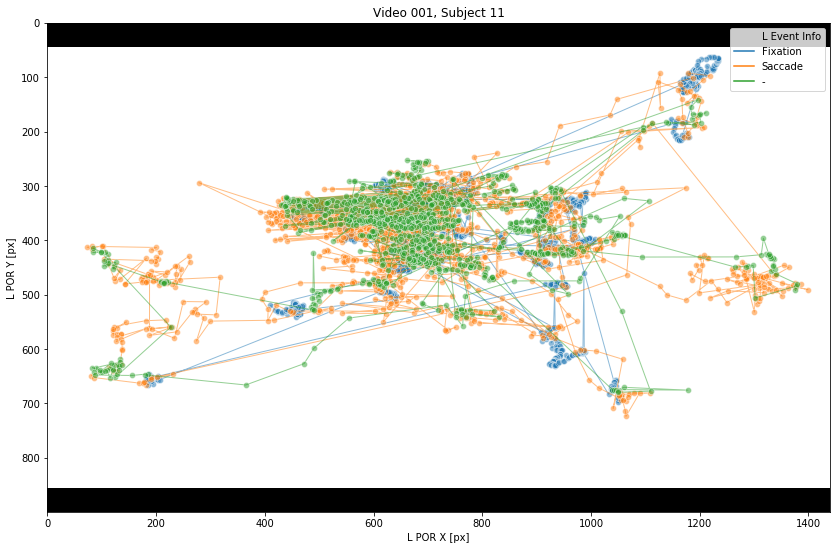

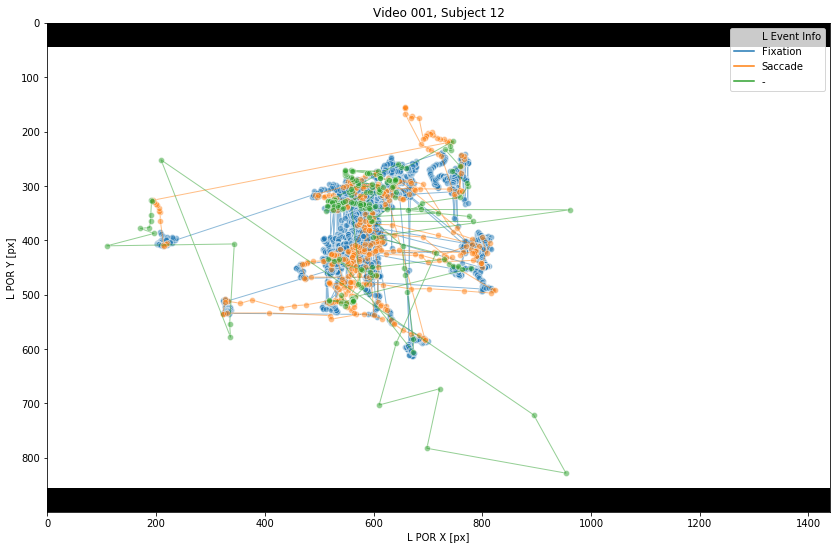

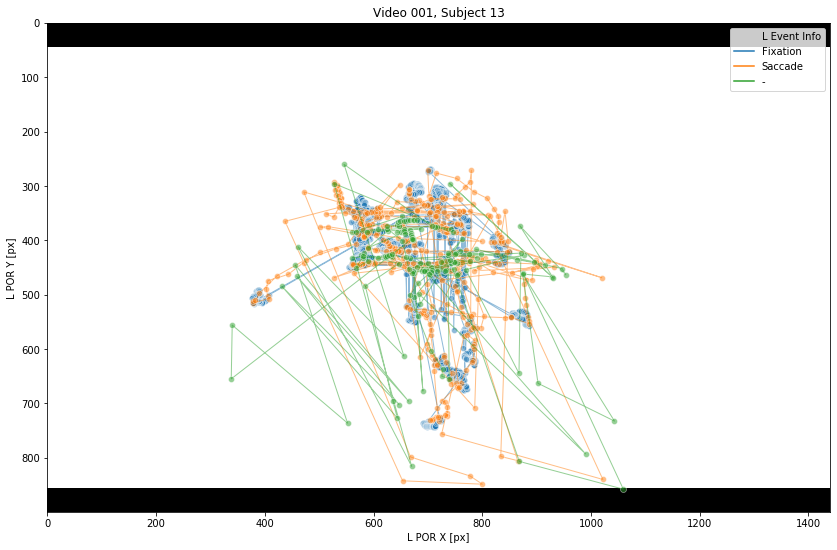

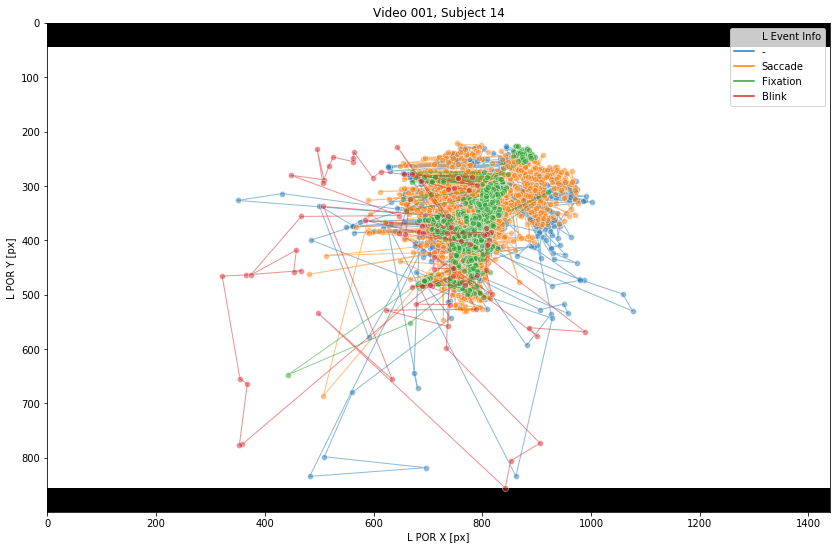

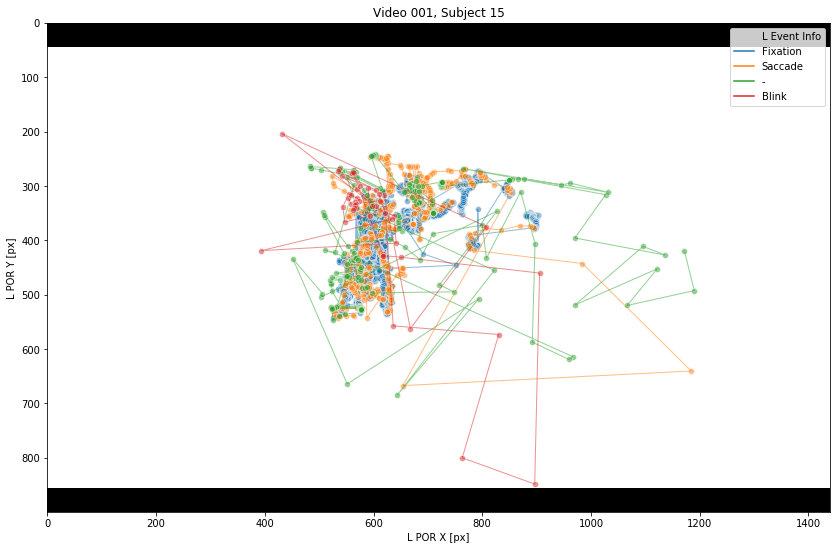

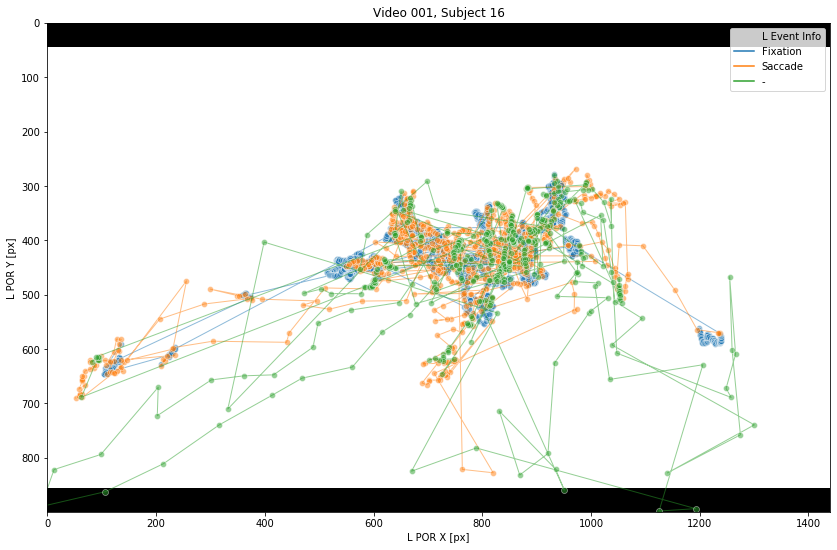

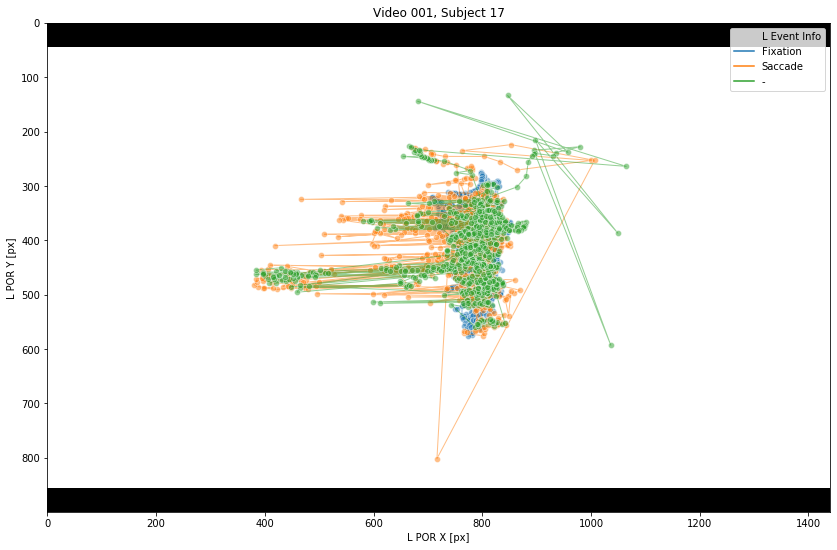

In [63]:
v = 1
nb_f = nframes[v-1]
for s in range(1,18):
    fix, ax = plt.subplots(figsize=(14.4,9))

    display = Rectangle((0,0),screen_res_x,screen_res_y,linewidth=1,facecolor='black')
    frame = Rectangle((0,b), video_res_x / a, video_res_y / a,linewidth=1,facecolor='white')


    filename = f'P{s:02}/P{s:02}_Trail{v:03}.txt'
    txtloc = GAZEPATH+filename
    df = pd.read_csv(txtloc, sep='\t')
    df = df.drop(columns=['Type', 'Trial', 'L Dia X [px]', 'L Dia Y [px]'])
    # df['Time']-=df['Time'][0]
    df = df[df['L POR Y [px]'] > 0.1]
    df = df[df['L POR Y [px]'] < screen_res_y]
    df = df[df['L POR X [px]'] < screen_res_x]
    ax = sns.lineplot(x='L POR X [px]', y='L POR Y [px]', hue='L Event Info',  marker="o", alpha=0.5, sort=False, lw=1, data=df)#, legend=False)

    ax.imshow(np.zeros((screen_res_y,screen_res_x)))
    # Add the patch to the Axes
    ax.add_patch(display)
    ax.add_patch(frame)
    plt.title(f'Video {v:03}, Subject {s:02}')
    plt.savefig(f'scanpath_trace/vid{v:03}_subj{s:02}.png')
    plt.show()

### quick check how noisy the data is 

Text(0.5, 1.0, 'vid 1, subj, 1 first second')

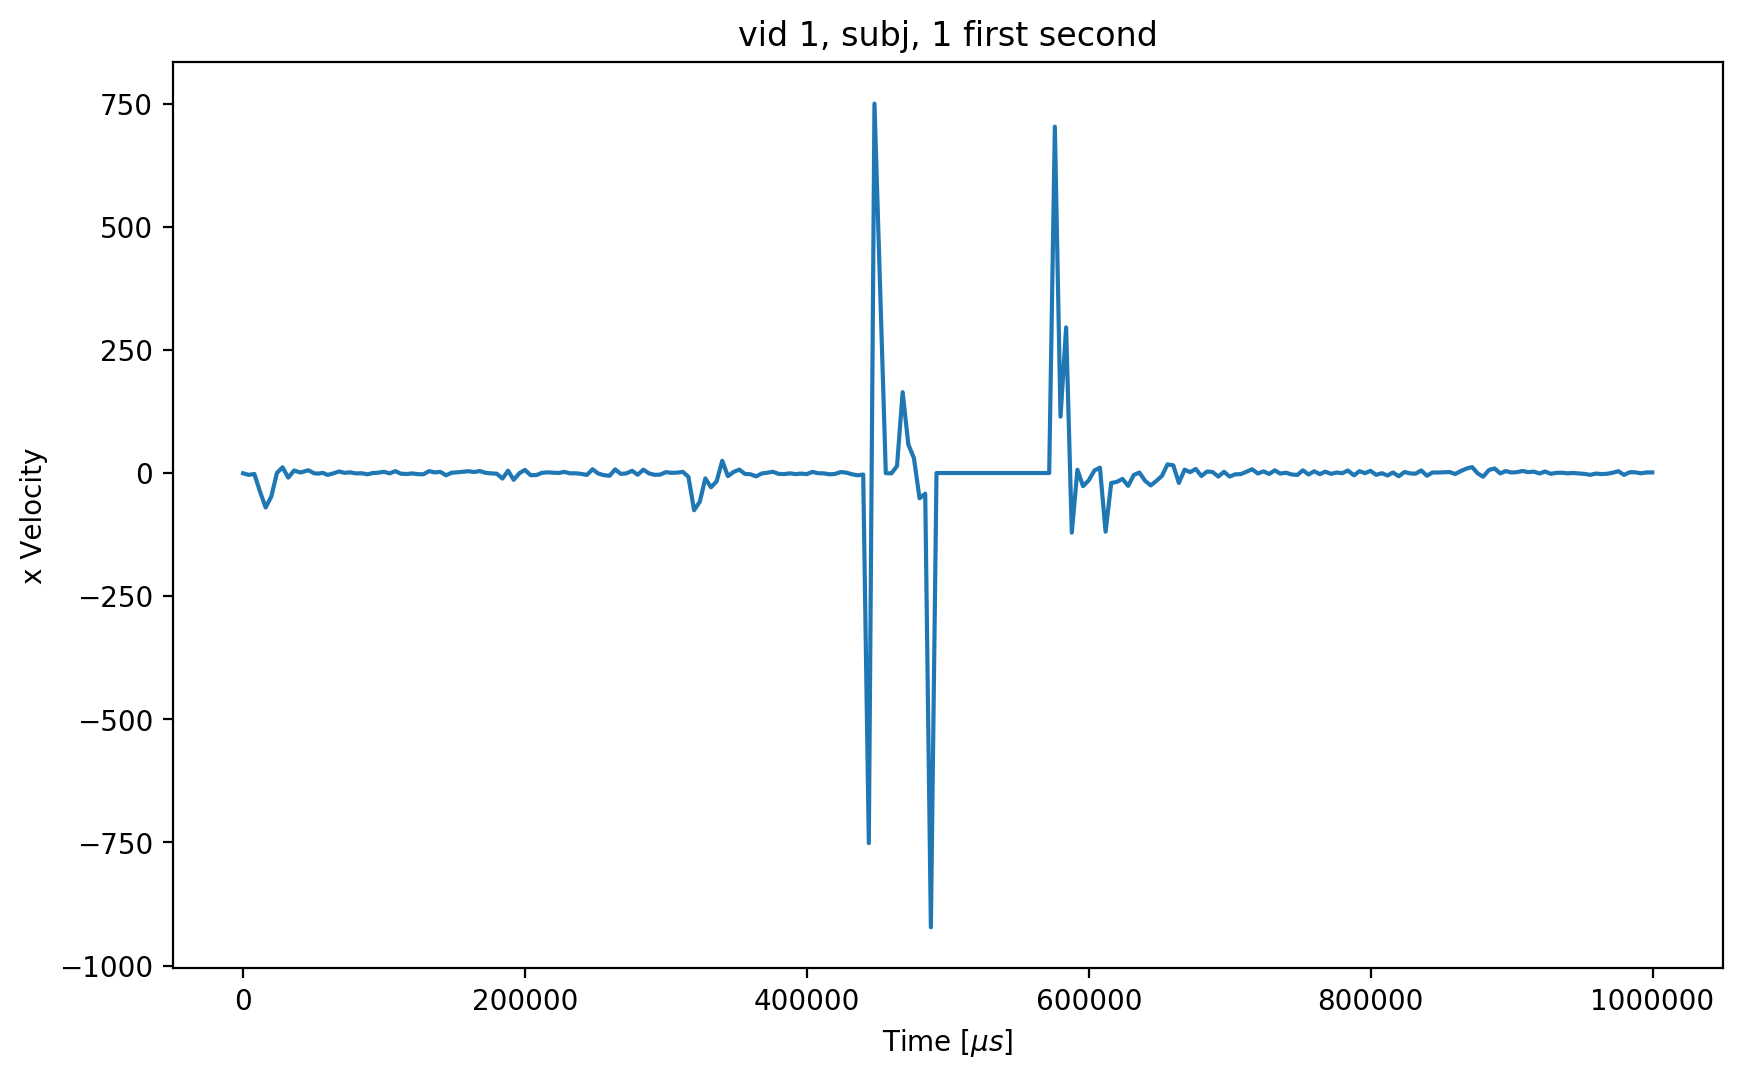

In [4]:
v=1
s=1
steps = 250 # equv 1sec
filename = f'P{s:02}/P{s:02}_Trail{v:03}.txt'
txtloc = GAZEPATH+filename
df = pd.read_csv(txtloc, sep='\t')
df = df.drop(columns=['Type', 'Trial', 'L Dia X [px]', 'L Dia Y [px]'])
df['Time']-=df['Time'][0]
plt.figure(figsize=(10,6), dpi=200)
sns.lineplot(df['Time'][:steps], np.array(df['L POR X [px]'][1:steps+1])- np.array(df['L POR X [px]'][:steps]))
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('x Velocity')
plt.title('vid 1, subj, 1 first second')

## 19 inch display, resolution: 1440x900, 250Hz, headrest with distance around 68cm 

## Processed with Dorr and exported to .arff

### Run for first 50 videos

In [4]:
ARFFPATH = '/home/nico/project_code/deep_em_classifier/DHF1K_arff/events_vid1-50_600-650'

eventlist_all50 = []
noiselist = []
for v in [0,1]:
    eventlistsubj = []
    for s in range(17):
        eventlist = np.load(ARFFPATH+f'/vid{v+1:03}_sub{s+1:02}_eventlist.npy')
        counter_eventlist_dict = Counter(eventlist)
        noise_ratio = counter_eventlist_dict['NOISE'] / len(eventlist) * 100
        noiselist.append(noise_ratio)
        print(f'Video {v+1:02}, Subject {s+1:02}, Noise ratio: {noise_ratio:.2f}%', counter_eventlist_dict)
        eventlistsubj.append(eventlist)
    eventlist_all50.append(eventlistsubj)
print(f'Average noise ratio: {np.average(noiselist):.2f}%')

Video 01, Subject 01, Noise ratio: 13.72% Counter({'FIX': 3128, 'NOISE': 555, 'SP': 236, 'SACCADE': 125})
Video 01, Subject 02, Noise ratio: 59.07% Counter({'NOISE': 2396, 'FIX': 1177, 'SP': 351, 'SACCADE': 132})
Video 01, Subject 03, Noise ratio: 1.53% Counter({'FIX': 2478, 'SP': 1329, 'SACCADE': 189, 'NOISE': 62})
Video 01, Subject 04, Noise ratio: 66.39% Counter({'NOISE': 2688, 'FIX': 853, 'SP': 354, 'SACCADE': 154})
Video 01, Subject 05, Noise ratio: 42.69% Counter({'SP': 1769, 'NOISE': 1741, 'FIX': 426, 'SACCADE': 142})
Video 01, Subject 06, Noise ratio: 89.47% Counter({'NOISE': 3646, 'SP': 231, 'FIX': 198})
Video 01, Subject 07, Noise ratio: 100.00% Counter({'NOISE': 4074})
Video 01, Subject 08, Noise ratio: 20.07% Counter({'FIX': 2291, 'NOISE': 811, 'SP': 707, 'SACCADE': 231})
Video 01, Subject 09, Noise ratio: 10.04% Counter({'SP': 1976, 'FIX': 1488, 'NOISE': 408, 'SACCADE': 190})
Video 01, Subject 10, Noise ratio: 36.86% Counter({'NOISE': 1490, 'SP': 1161, 'FIX': 1152, 'SACCAD